[![Fixel Algorithms](https://i.imgur.com/AqKHVZ0.png)](https://fixelalgorithms.gitlab.io/)

# t-SNE Demo

A notebook dedicated to the T Distributed Stochastic Neighbor Embedding.


> Notebook by:
> - Royi Avital RoyiAvital@fixelalgorithms.com

## Revision History

| Version | Date       | User        |Content / Changes                                                   |
|---------|------------|-------------|--------------------------------------------------------------------|
| 1.0.000 | 13/04/2024 | Royi Avital | First version                                                      |

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/AIProgram/2024_02/0068ManifoldLearningTSNE.ipynb)

In [5]:
# Import Packages

# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Machine Learning
from sklearn.datasets import fetch_openml
from sklearn.manifold import TSNE

# Miscellaneous
import math
import os
from platform import python_version
import random
import timeit

# Typing
from typing import Callable, Dict, List, Optional, Self, Set, Tuple, Union

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter
from IPython import get_ipython
from IPython.display import Image
from IPython.display import display
from ipywidgets import Dropdown, FloatSlider, interact, IntSlider, Layout, SelectionSlider
from ipywidgets import interact

## Notations

* <font color='red'>(**?**)</font> Question to answer interactively.
* <font color='blue'>(**!**)</font> Simple task to add code for the notebook.
* <font color='green'>(**@**)</font> Optional / Extra self practice.
* <font color='brown'>(**#**)</font> Note / Useful resource / Food for thought.

Code Notations:

```python
someVar    = 2; #<! Notation for a variable
vVector    = np.random.rand(4) #<! Notation for 1D array
mMatrix    = np.random.rand(4, 3) #<! Notation for 2D array
tTensor    = np.random.rand(4, 3, 2, 3) #<! Notation for nD array (Tensor)
tuTuple    = (1, 2, 3) #<! Notation for a tuple
lList      = [1, 2, 3] #<! Notation for a list
dDict      = {1: 3, 2: 2, 3: 1} #<! Notation for a dictionary
oObj       = MyClass() #<! Notation for an object
dfData     = pd.DataFrame() #<! Notation for a data frame
dsData     = pd.Series() #<! Notation for a series
hObj       = plt.Axes() #<! Notation for an object / handler / function handler
```

### Code Exercise

 - Single line fill

 ```python
 vallToFill = ???
 ```

 - Multi Line to Fill (At least one)

 ```python
 # You need to start writing
 ????
 ```

 - Section to Fill

```python
#===========================Fill This===========================#
# 1. Explanation about what to do.
# !! Remarks to follow / take under consideration.
mX = ???

???
#===============================================================#
```

In [6]:
# Configuration
# %matplotlib inline

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

# Matplotlib default color palette
lMatPltLibclr = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# sns.set_theme() #>! Apply SeaBorn theme

runInGoogleColab = 'google.colab' in str(get_ipython())


In [7]:
# Constants

FIG_SIZE_DEF    = (8, 8)
ELM_SIZE_DEF    = 50
CLASS_COLOR     = ('b', 'r')
EDGE_COLOR      = 'k'
MARKER_SIZE_DEF = 10
LINE_WIDTH_DEF  = 2


In [8]:
# Courses Packages
import sys
sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../../')
from utils.DataVisualization import PlotMnistImages


In [9]:
# General Auxiliary Functions

def PlotEmbeddedImg(mZ: np.ndarray, mX: np.ndarray, vL: np.ndarray = None, numImgScatter: int = 50, imgShift: float = 5.0, tImgSize: Tuple[int, int] = (28, 28), hA: plt.Axes = None, figSize: Tuple[int, int] = FIG_SIZE_DEF, markerSize: int = MARKER_SIZE_DEF, edgeColor = EDGE_COLOR, lineWidth: int = LINE_WIDTH_DEF, axisTitle: str = None):

    if hA is None:
        hF, hA = plt.subplots(figsize = figSize)
    else:
        hF = hA.get_figure()
    
    numSamples = mX.shape[0]
    
    lSet = list(range(1, numSamples))
    lIdx = [0] #<! First image
    for ii in range(numImgScatter):
        mDi  = sp.spatial.distance.cdist(mZ[lIdx, :], mZ[lSet, :])
        vMin = np.min(mDi, axis = 0)
        idx  = np.argmax(vMin) #<! Farthest image
        lIdx.append(lSet[idx])
        lSet.remove(lSet[idx])
    
    for ii in range(numImgScatter):
        idx = lIdx[ii]
        x0  = mZ[idx, 0] - imgShift
        x1  = mZ[idx, 0] + imgShift
        y0  = mZ[idx, 1] - imgShift
        y1  = mZ[idx, 1] + imgShift
        mI  = np.reshape(mX[idx, :], tImgSize)
        hA.imshow(mI, aspect = 'auto', cmap = 'gray', zorder = 2, extent = (x0, x1, y0, y1))
    
    if vL is not None:
        vU = np.unique(vL)
        numClusters = len(vU)
    else:
        vL = np.zeros(numSamples)
        vU = np.zeros(1)
        numClusters = 1

    for ii in range(numClusters):
        vIdx = vL == vU[ii]
        hA.scatter(mZ[vIdx, 0], mZ[vIdx, 1], s = markerSize, edgecolor = edgeColor, label = ii)
    
    hA.set_xlabel('${{x}}_{{1}}$')
    hA.set_ylabel('${{x}}_{{2}}$')
    if axisTitle is not None:
        hA.set_title(axisTitle)
    hA.grid()
    hA.legend()

    return hA


## Dimensionality Reduction by t-SNE

The t-SNE method was invented in Google with the motivation of analyzing the weights of Deep Neural Networks (High dimensional data).  
So its main use, originally, was visualization. Yet in practice it is one of the most powerful dimensionality reduction methods.

In this notebook:

 - We'll apply the t-SNE algorithm on the MNIST data set.
 - We'll compare the results to the results by Kernel PCA or IsoMap. 

In [10]:
# Parameters

# Data
numRows  = 3
numCols  = 3
tImgSize = (28, 28)

numSamples = 5_000

# Model
lowDim      = 2
paramP      = 10
metricType  = 'l2'

# Visualization
imgShift        = 5
numImgScatter   = 70


## Generate / Load Data

Load the MNIST data.

* <font color='red'>(**?**)</font> What's the dimension of the underlying manifold of the data?

In [11]:
# Load Data

mX, vY = fetch_openml('mnist_784', version = 1, return_X_y = True, as_frame = False, parser = 'auto')

print(f'The features data shape: {mX.shape}')
print(f'The features data type: {mX.dtype}')

The features data shape: (70000, 784)
The features data type: int64


In [12]:
# Sub Sample the Data

vIdx = np.random.choice(mX.shape[0], numSamples, replace = False)
mX = mX[vIdx]
vY = vY[vIdx]

print(f'The features data shape: {mX.shape}')

The features data shape: (5000, 784)


### Plot Data

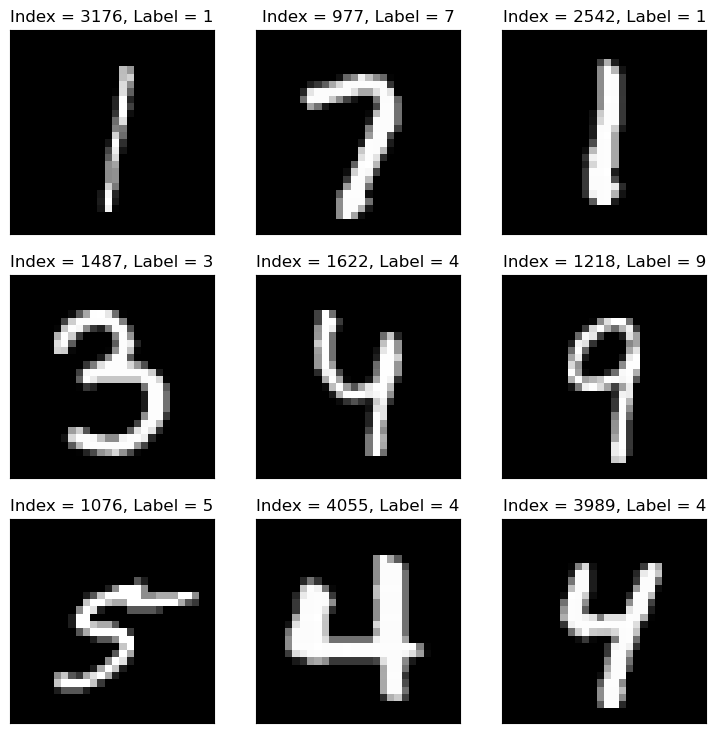

In [13]:
# Plot the Data

hF = PlotMnistImages(mX, vY, numRows = numRows, numCols = numCols, tuImgSize = tImgSize)

plt.show()

## Applying Dimensionality Reduction - t-SNE

The t-SNE algorithm is an improvement of the SNE algorithm:

![](https://i.imgur.com/CNK26ly.png)

The addition of the heavy tail t Student distribution allowed improving the algorithm by keeping the local structure.  
It allowed the model to have small penalty even for cases points are close in high dimension but far in low dimension.

We'll use SciKit Learn's implementation of the algorithm [`TSNE`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

* <font color='brown'>(**#**)</font> The t-SNE algorithm preserves local structure.
* <font color='brown'>(**#**)</font> The t-SNE algorithm is random by its nature.
* <font color='brown'>(**#**)</font> The t-SNE algorithm is heavy to compute.
* <font color='brown'>(**#**)</font> The t-SNE algorithm does not support out of sample data inherently.



In [14]:
# Apply the t-SNE

# Construct the object
oTsneDr = TSNE(n_components = lowDim, perplexity = paramP, metric = metricType)
# Build the model and transform data
mZ = oTsneDr.fit_transform(mX)

* <font color='red'>(**?**)</font> In production, what do we deliver?
* <font color='red'>(**?**)</font> Look at the documentation of [`TSNE`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), why don't we have the `transform()` method?

Text(0.5, 1.0, 'Low Dimension Representation by t-SNE with Perplexity = 10')

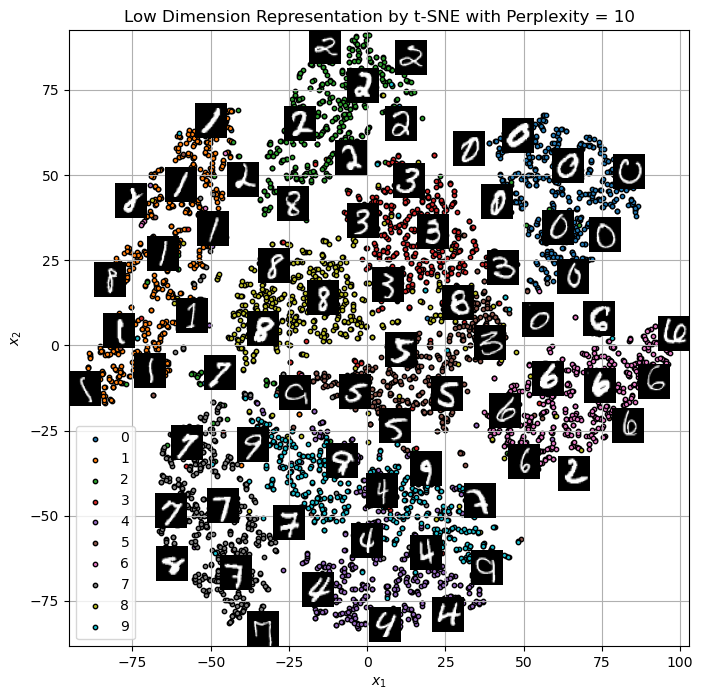

In [15]:
# Plot the Low Dimensional Data (With the Digits)

hA = PlotEmbeddedImg(mZ, mX, vL = vY, numImgScatter = numImgScatter, imgShift = imgShift, tImgSize = tImgSize)
hA.set_title(f'Low Dimension Representation by t-SNE with Perplexity = {paramP}')

* <font color='blue'>(**!**)</font> Change the `perplexity` parameter and see the results.
* <font color='blue'>(**!**)</font> Apply the KernelPCA or IsoMap to the data and compare results (Run time as well).

## ISO MAP

In [31]:
from sklearn.manifold import Isomap
# Applying Isomap
iso = Isomap(n_neighbors=10, n_components=2)
X_iso = iso.fit_transform(mX/100)




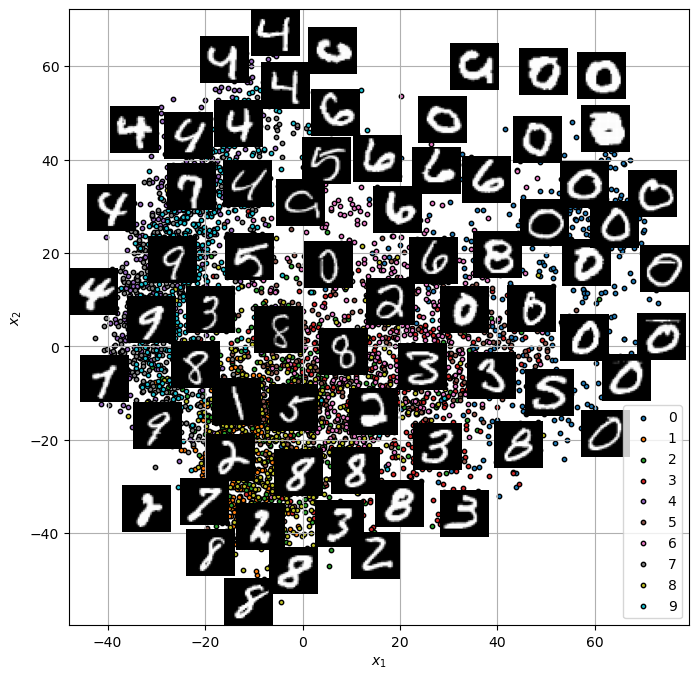

In [32]:
hA = PlotEmbeddedImg(X_iso, mX, vL = vY, numImgScatter = numImgScatter, imgShift = imgShift, tImgSize = tImgSize)
